In [73]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
import phik
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from ctgan import CTGAN
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import RANSACRegressor
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
pd.set_option('display.float_format', '{:.2f}'.format)

<h1>Fixing the Regression</h1>


<b>Summary from the report</b>
<ul>
<li>Remove from the List</li>
<li>Cap the outliers, especially for the 6 focused on columns</li>
<li>Next Homework, fix distribution with synthetic Data for the ones where autovizviz, ydata and SHAP say the importance is higher (only for the kept columns, maybe redo all the reports with the cut down data)</li>
</ul>

In [75]:
df = pd.read_csv("Clean_Zillow.csv")
df.head()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,state,yearBuilt,latitude,rentZestimate,city,zestimateLowPercent,...,bedrooms,price,zestimateHighPercent,homeType_APARTMENT,homeType_CONDO,homeType_LOT,homeType_MANUFACTURED,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE
0,-149.91,2020.00,0.00,2840,AK,1959.00,61.22,3142.00,Anchorage,12.00,...,3.00,676100,13.00,0,0,0,0,0,1,0
1,-149.91,2020.00,0.00,2934,AK,1961.00,61.22,3113.00,Anchorage,12.00,...,3.00,698600,13.00,0,0,0,0,0,1,0
2,-149.91,2020.00,0.00,4187,AK,1983.00,61.22,4282.00,Anchorage,12.00,...,4.00,996800,14.00,0,0,0,0,0,1,0
3,-149.91,2020.00,0.00,2920,AK,1947.00,61.22,3458.00,Anchorage,15.00,...,5.00,695300,16.00,0,0,0,0,0,1,0
4,-149.91,2020.00,0.00,4100,AK,2000.00,61.22,4161.00,Anchorage,18.00,...,4.00,976100,24.00,0,1,0,0,0,0,0


<b>Removing</b>

In [76]:
dropable=["state","city",'yearBuilt','zestimateLowPercent','zestimate','zestimateHighPercent','latitude','zipcode','timeOnZillow']
df=df.drop(dropable,axis=1)


X = df.drop(["price"], axis=1)
y = df['price']


<b>Combining</b>

In [77]:
#Chatgpt
# Example: Combine the sparse columns into an "Other" category
sparse_columns = ['homeType_LOT', 'homeType_MANUFACTURED', 'homeType_APARTMENT','homeType_TOWNHOUSE','homeType_MULTI_FAMILY']

# Create a new 'Other' column that combines the sparse categories
df['homeType_OTHER'] = df[sparse_columns].sum(axis=1)

# Drop the original sparse columns
df = df.drop(columns=sparse_columns)

# Check the updated DataFrame
df.head()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
0,-149.91,2020.00,0.00,2840,3142.00,2668.00,1.31,2.00,3.00,676100,0,1,0
1,-149.91,2020.00,0.00,2934,3113.00,3179.00,1.31,2.00,3.00,698600,0,1,0
2,-149.91,2020.00,0.00,4187,4282.00,3059.00,1.31,3.00,4.00,996800,0,1,0
3,-149.91,2020.00,0.00,2920,3458.00,1642.00,1.31,2.00,5.00,695300,0,1,0
4,-149.91,2020.00,0.00,4100,4161.00,4483.00,1.31,4.00,4.00,976100,1,0,0


<b>Cap/Outlier Removal</b>

<b>Distribution</b>

In [78]:
#Distribution of the Focused on variable
#Focused Variables are:
#rentZestimate, livingArea, propertyTaxRate, bathrooms, bedrooms, price

<b>Property Tax Rate</b>

<Axes: xlabel='propertyTaxRate', ylabel='Count'>

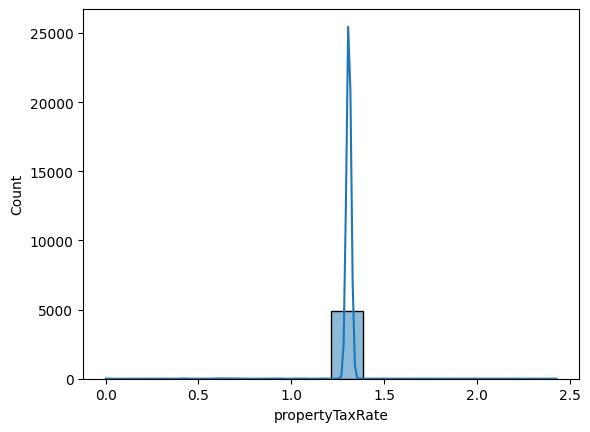

In [79]:
sns.histplot(data=df, x="propertyTaxRate", kde=True)

In [80]:
#we have 5k houses, so i will use SMOTE and then undersample
# after some consideration first undersampeling then ctgan is better

In [ ]:
target = "propertyTaxRate"

# typical X/y split, choose target variable as needed
X = df.drop([target], axis=1)
y = df[target]

# initialize CTGAN and start training
# CTGAN is based on neural networks (GAN), that's why we have to specify epochs
ctgan = CTGAN()
ctgan.fit(df, epochs=100)

# get the data from the model
num_new_data = 100000
synthetic_df = ctgan.sample(num_new_data)


In [ ]:
synthetic_df.describe()

,longitude,countyFIPS,monthlyHoaFee,annualHomeownersInsurance,rentZestimate,livingArea,propertyTaxRate,bathrooms,bedrooms,price,homeType_CONDO,homeType_SINGLE_FAMILY,homeType_OTHER
count,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00
mean,-148.99,2969.31,27.68,1848.36,2456.26,1767.10,1.31,1.98,3.29,363327.35,0.14,0.78,0.24
std,7.39,6196.68,106.08,786.19,741.49,870.64,0.05,0.61,1.16,134790.77,0.34,0.42,0.43
min,-150.30,1553.92,-346.39,-211.00,-66.69,-1083.52,-0.05,-1.76,0.54,-382395.00,0.00,0.00,0.00
25%,-149.98,2038.51,-5.03,1406.00,1897.62,1122.58,1.31,1.96,2.14,292955.00,0.00,1.00,0.00
50%,-149.90,2067.57,2.36,1791.00,2457.48,1692.14,1.31,1.98,3.04,365683.00,0.00,1.00,0.00
75%,-149.82,2094.96,10.42,2170.00,2913.52,2128.78,1.31,2.01,4.03,423574.00,0.00,1.00,0.00
max,-44.81,74392.91,1689.14,7158.00,7045.32,9791.09,2.95,7.22,12.29,1806823.00,1.00,1.00,1.00


<Axes: xlabel='propertyTaxRate', ylabel='Count'>

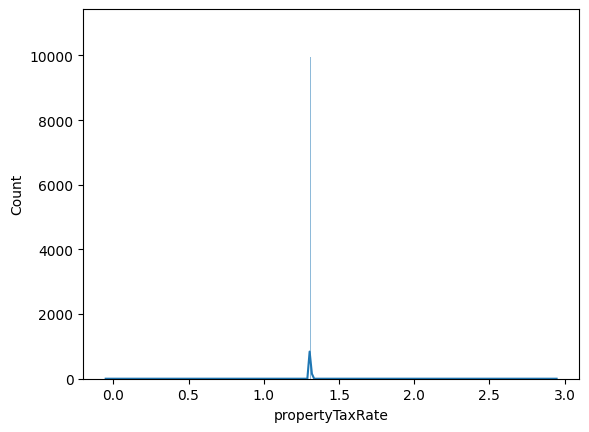

In [ ]:
sns.histplot(data=synthetic_df, x="propertyTaxRate", kde=True)

<Axes: >

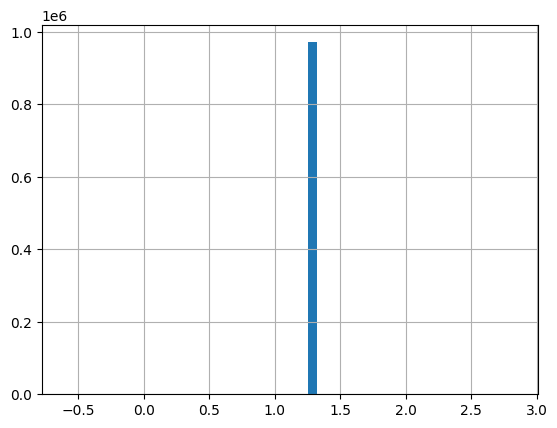

In [ ]:
ransac = RANSACRegressor(residual_threshold=np.std(y) * 1.5)
ransac.fit(X, y)

# now we have split the result into 
# inliers and outliers
# inliers => good data, follows the distribution nicely
# outliers => are far away from the main distribution
# the ~-sign (tilde) in pandas DataFrames means "the opposite of"
# so in this case => get everything from DataFrame EXCEPT the inliers
inlier_mask = ransac.inlier_mask_
outliers = df[~inlier_mask]
inliers = df[inlier_mask]

print(f"Inliers: {len(inliers)}")
print(f"Outliers: {len(outliers)}")


<Axes: xlabel='propertyTaxRate', ylabel='Count'>

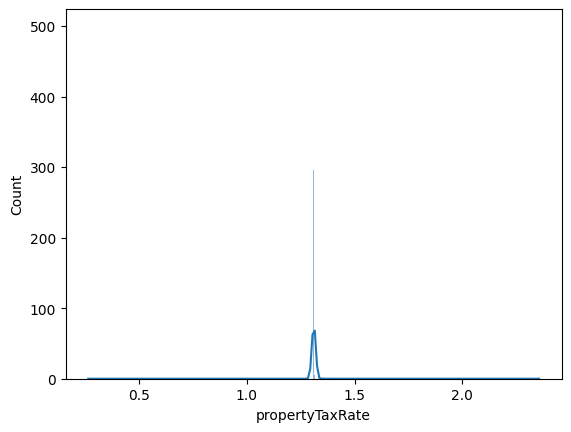

In [ ]:
from sklearn.ensemble import IsolationForest

# adjust the contamination rate as you see fit
# for example, if you expect 5% of the data to be outliers
# you can use 0.05 etc. 
iso = IsolationForest(contamination=0.1) 

# fit isolation forest
y_pred = iso.fit_predict(df)

# filter outliers only
outliers = df[y_pred != 1]
df = df.drop(outliers.index)

<b>Finished Product</b>


In [ ]:
df.to_csv('fixed_Zillow.csv', index=False)